本文档用于处理IRIS

In [2]:
import sunpy
import sunpy.map
import numpy as np
from math import *
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sunpy.coordinates import frames
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from matplotlib.patches import ConnectionPatch
import os,cv2
from scipy.optimize import fmin
from scipy.ndimage import affine_transform
import shutil
from scipy.io import readsav
import glob
from matplotlib.patches import Rectangle
from scipy.ndimage import zoom

c:\Users\19671\anaconda3\envs\sun\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
file_list=glob.glob(r'D:\Learning\PHD1st\magnetic_reconnecion\data\IRIS\iris_l2_20240618_163141_3602506433_raster\*.fits')
rsm=fits.open(file_list[399])
rsm_1400=fits.open(r'D:\Learning\PHD1st\magnetic_reconnecion\data\IRIS\iris_l2_20240618_163141_3602506433_SJI_1400_t000.fits')

In [4]:
solar_xy=readsav(r'D:\Learning\PHD1st\magnetic_reconnecion\data_process\solar_xy.sav')

In [5]:
print(solar_xy.keys())

dict_keys(['solar_x', 'solar_y'])


In [6]:
solar_x=solar_xy['solar_x']
solar_y=solar_xy['solar_y']

In [7]:
siiv=rsm[3].data

In [8]:
sji1400=rsm_1400[0].data

In [9]:
new_map=np.log(sji1400[799,:,:]+201)
print(new_map.max(),new_map.min())

9.221997 0.0


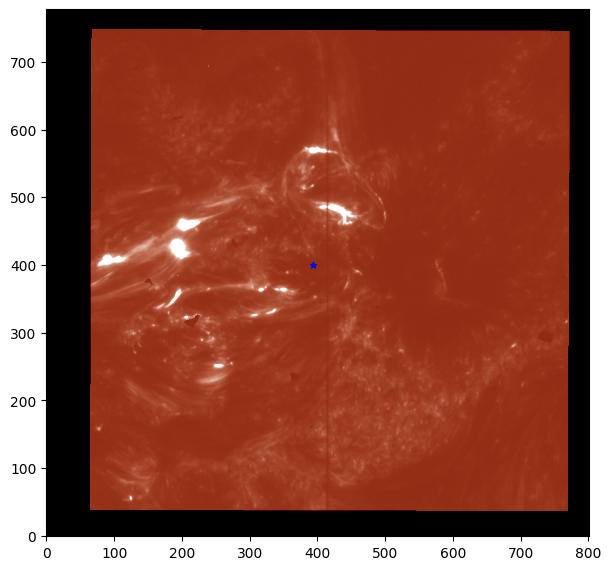

In [10]:
plt.figure(figsize=(7,7))
plt.imshow(new_map,origin='lower',cmap='irissji1400',vmin=4.8,vmax=6)
fig_x=348/354.533*400.5
plt.scatter(fig_x,400,s=20,marker='*',c='blue')

In [11]:
print(sji1400[799,:,:].mean(),sji1400[799,:,:].max(),sji1400[799,:,:].min())

-27.217752 9916.25 -200.0


In [12]:
three_sji=readsav(r'D:\Learning\PHD1st\magnetic_reconnecion\data_process\three_sji_image.sav')
print(three_sji.keys())

dict_keys(['matrix_struct'])


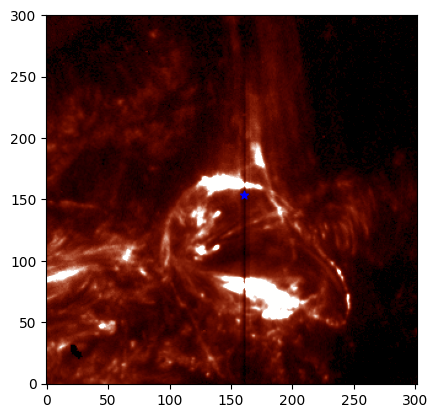

In [65]:
fig1=three_sji['matrix_struct'][0][0]
plt.imshow(fig1,origin='lower',cmap='irissji1400',vmin=0.5,vmax=20)
fig_x=(356.57254-330)/50*302
target_y=560
fig_y=(405+solar_y[target_y,0])/50*301
plt.scatter(fig_x,fig_y,marker='*',color='blue')

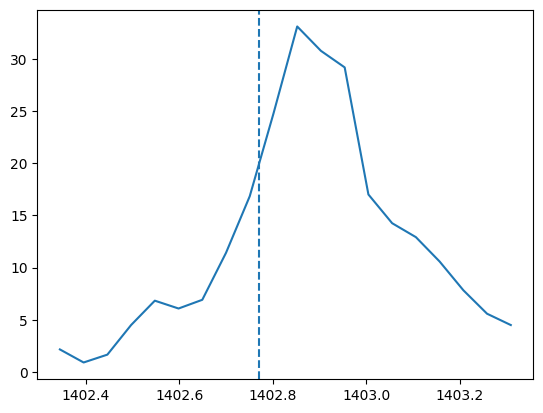

In [66]:
wave_x=np.arange(1398.28,1398.28+164*0.0508,0.0508)
wave_y=rsm[4].data[4,target_y:target_y+3,:].mean(axis=0)
plt.plot(wave_x[80:100],wave_y[80:100])
plt.axvline(x=1402.77,linestyle='--')

In [58]:
print(wave_x[80:100])
print(wave_y[80:100])

[1402.344  1402.3948 1402.4456 1402.4964 1402.5472 1402.598  1402.6488
 1402.6996 1402.7504 1402.8012 1402.852  1402.9028 1402.9536 1403.0044
 1403.0552 1403.106  1403.1568 1403.2076 1403.2584 1403.3092]
[ 1.1666666  0.6666667 -1.0833334 -1.25      -1.25      -2.
  3.1666667  7.6666665  5.4166665 11.416667  15.916667  10.833333
  1.25       1.1666666  1.4166666  2.        -0.9166667  5.1666665
  3.1666667  3.       ]


拟合参数:
峰值振幅 a = 28.82723314300336
均值 μ = 1402.895136734547
标准差 σ = 0.16514479277797806


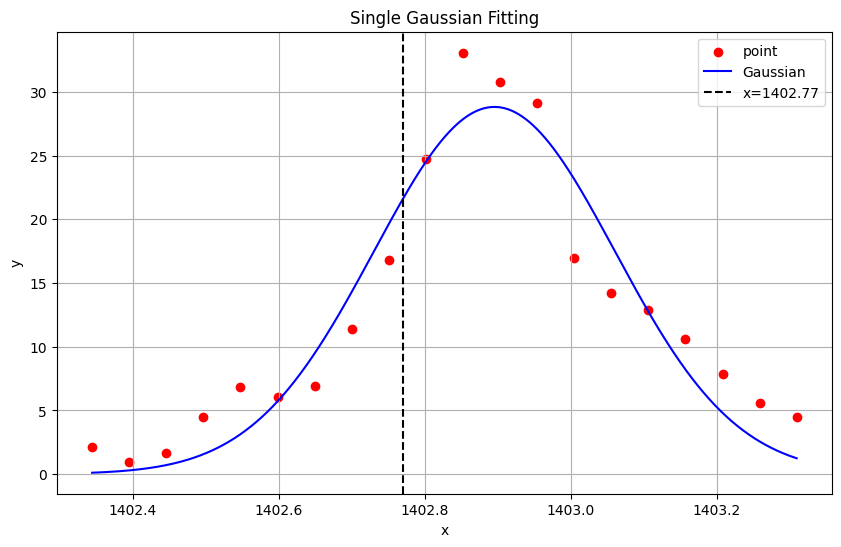

In [67]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 数据
x=wave_x[80:100]
y=wave_y[80:100]
# 定义高斯函数
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# 设定初始参数
mu_initial = 1402.77  # 参考给定均值
a_initial = max(y)  # 初始振幅设为 y 的最大值
sigma_initial = 0.05  # 初始标准差

initial_guess = [a_initial, mu_initial, sigma_initial]

# 进行高斯拟合
popt, pcov = curve_fit(gaussian, x, y, p0=initial_guess)

# 获取拟合参数
a_fit, x0_fit, sigma_fit = popt

# 打印拟合结果
print(f"拟合参数:")
print(f"峰值振幅 a = {a_fit}")
print(f"均值 μ = {x0_fit}")
print(f"标准差 σ = {sigma_fit}")

# 生成拟合曲线
x_fit = np.linspace(min(x), max(x), 1000)
y_fit = gaussian(x_fit, *popt)

# 绘制图像
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="point", color="red")  # 画原始数据点
plt.plot(x_fit, y_fit, label="Gaussian", color="blue")  # 画拟合曲线
plt.axvline(x=1402.77, color='black', linestyle='--', linewidth=1.5, label="x=1402.77")  # 画参考竖线
plt.title("Single Gaussian Fitting")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()


In [47]:
all_sji_image=readsav(r'D:\Learning\PHD1st\magnetic_reconnecion\data_process\all_sji_image.sav')['matrix_struct']

In [ ]:
for i in range(990):
    print(all_sji_image[i][0].shape)

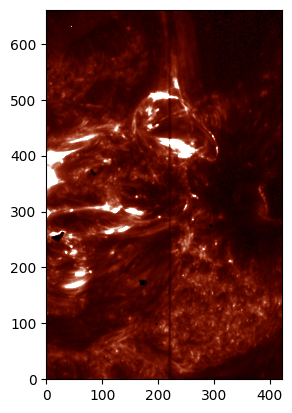

In [57]:
plt.imshow(all_sji_image[799][0],cmap='irissji1400',vmin=0,vmax=20,origin='lower')

In [90]:
def gaussian(x,a,x0,sigma,noise):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+noise

doppler_vel=np.zeros((220))
wave_x=np.arange(1398.28,1398.28+164*0.0508,0.0508)
for i in range(220):
    print(i)
    wave_y=rsm[4].data[4,65+i*3:68+i*3,:].mean(axis=0)

    x=wave_x[80:100]
    y=wave_y[80:100]
    #初始参数
    mu_initial=1402.77
    a_initial=np.mean(y)
    noise_initial=0
    sigma_initial=0.05
    initial_guess=[a_initial,mu_initial,sigma_initial,noise_initial]
    popt,pcov=curve_fit(gaussian,x,y,p0=initial_guess)
    #获取参数
    a_fit,mu_fit,sigma_fit,noise_fit=popt

    #计算多普勒速度
    doppler_vel[i]=(mu_fit-mu_initial)/mu_initial*299792.458

    y_fit=gaussian(x,*popt)
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, label="point", color="red")  # 画原始数据点
    plt.plot(x, y_fit, label="Gaussian", color="blue")  # 画拟合曲线
    plt.axvline(x=1402.77, color='black', linestyle='--', linewidth=1.5, label="x=1402.77")  # 画参考竖线
    plt.title("Single Gaussian Fitting")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid()
    plt.savefig(r'D:\Learning\PHD1st\magnetic_reconnecion\data\IRIS\gaussian_fit_fig\\'+str(i)+'.png')
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


C:\Users\19671\AppData\Local\Temp\ipykernel_11560\2940082366.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov=curve_fit(gaussian,x,y,p0=initial_guess)


60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [93]:
for i in range(168,220):
    print(i)
    wave_y=rsm[4].data[4,65+i*3:68+i*3,:].mean(axis=0)

    x=wave_x[60:100]
    y=wave_y[60:100]
    #初始参数
    mu_initial=1402.77
    a_initial=np.mean(y)
    noise_initial=0
    sigma_initial=0.05
    initial_guess=[a_initial,mu_initial,sigma_initial,noise_initial]
    popt,pcov=curve_fit(gaussian,x,y,p0=initial_guess)
    #获取参数
    a_fit,mu_fit,sigma_fit,noise_fit=popt

    #计算多普勒速度
    doppler_vel[i]=(mu_fit-mu_initial)/mu_initial*299792.458
    y_fit=gaussian(x,*popt)
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, label="point", color="red")  # 画原始数据点
    plt.plot(x, y_fit, label="Gaussian", color="blue")  # 画拟合曲线
    plt.axvline(x=1402.77, color='black', linestyle='--', linewidth=1.5, label="x=1402.77")  # 画参考竖线
    plt.title("Single Gaussian Fitting")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid()
    plt.savefig(r'D:\Learning\PHD1st\magnetic_reconnecion\data\IRIS\gaussian_fit_fig\\'+str(i)+'.png')
    plt.close()

168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


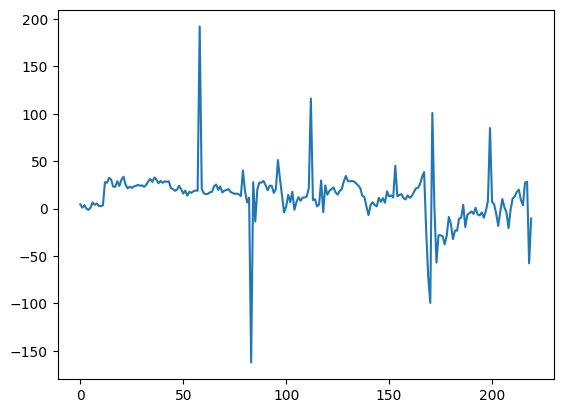

In [81]:
plt.plot(doppler_vel)

拟合参数:
峰值振幅 a = 56.779650507719
均值 μ = 1402.3668457629121
标准差 σ = 0.21460335737605482
-86.15995472506569


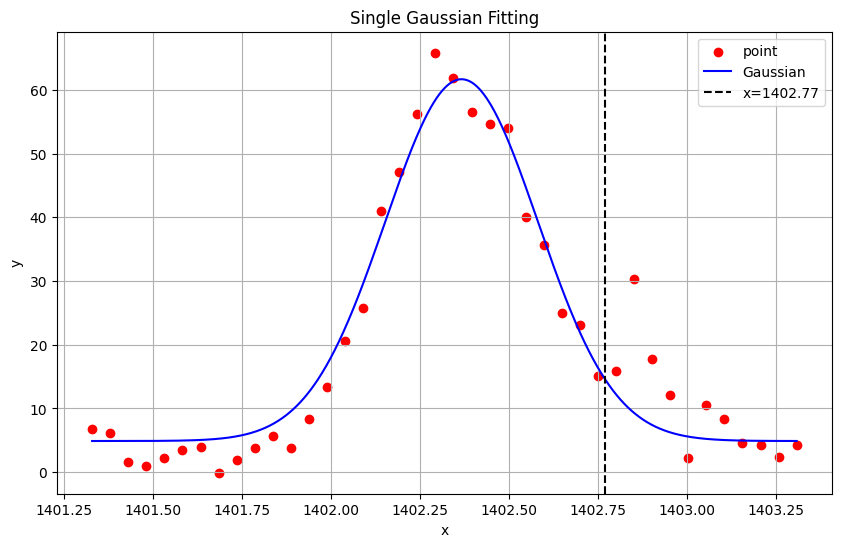

In [158]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
i=172
wave_y=rsm[4].data[4,65+i*3:68+i*3,:].mean(axis=0)
# 数据
x=wave_x[60:100]
y=wave_y[60:100]
# 定义高斯函数
def gaussian(x, a, x0, sigma,noise):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))+noise

# 设定初始参数
mu_initial = 1402.3  # 参考给定均值
a_initial = max(y)  # 初始振幅设为 y 的最大值
sigma_initial = 0.05  # 初始标准差
noise_initial=0
initial_guess = [a_initial, mu_initial, sigma_initial,noise_initial]

# 进行高斯拟合
popt, pcov = curve_fit(gaussian, x, y, p0=initial_guess)

# 获取拟合参数
a_fit, x0_fit, sigma_fit,noise_fit = popt

# 打印拟合结果
print(f"拟合参数:")
print(f"峰值振幅 a = {a_fit}")
print(f"均值 μ = {x0_fit}")
print(f"标准差 σ = {sigma_fit}")
print((x0_fit-1402.77)/1402.77*299792.458)
# 生成拟合曲线
x_fit = np.linspace(min(x), max(x), 1000)
y_fit = gaussian(x_fit, *popt)

# 绘制图像
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="point", color="red")  # 画原始数据点
plt.plot(x_fit, y_fit, label="Gaussian", color="blue")  # 画拟合曲线
plt.axvline(x=1402.77, color='black', linestyle='--', linewidth=1.5, label="x=1402.77")  # 画参考竖线
plt.title("Single Gaussian Fitting")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()


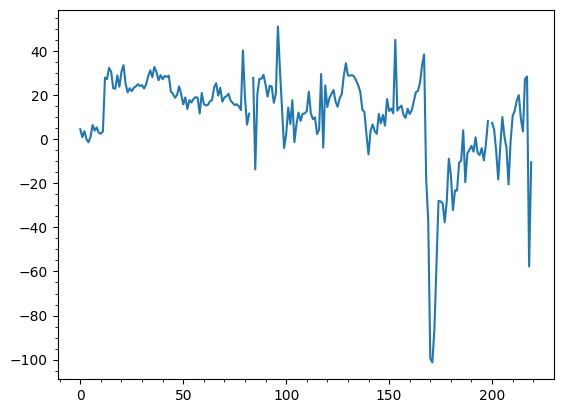

In [161]:
doppler_vel[172]=-86.1599
plt.plot(doppler_vel)
plt.minorticks_on()

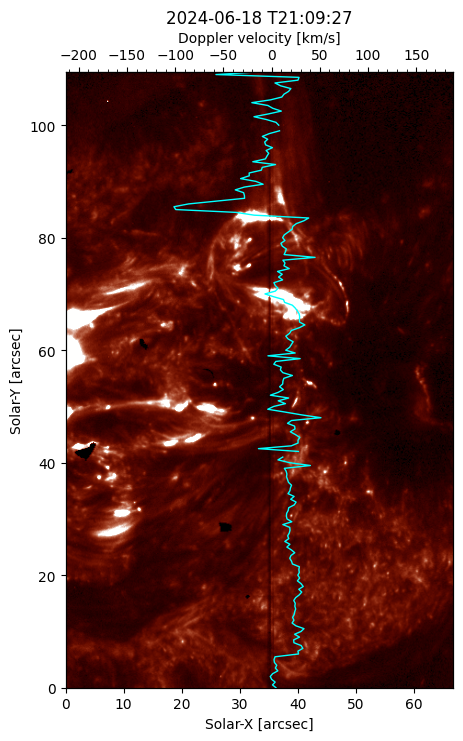

In [173]:
data1 = all_sji_image[799][0]  # 第一组数据 (402x660)
data2 = doppler_vel  # 第二组数据 (长度220)
# 创建画布
fig, left_ax = plt.subplots(figsize=(5,8))  

# 左侧：imshow 画 402x660 矩阵（转换为角秒单位）
im = left_ax.imshow(data1, aspect='auto', cmap='irissji1400', origin='lower', 
                    vmin=0, vmax=23,extent=[0, 402*0.166, 0, 660*0.166])  # 关键修改：设置坐标范围为角秒)
left_ax.set_xlabel("Solar-X [arcsec]")  # 修改x轴标签
left_ax.set_ylabel("Solar-Y [arcsec]")  # 修改y轴标签

# 计算坐标偏移量（转换为角秒单位）
offset_pixel = (356.5725 - 330)/50 * 402
offset_arcsec = offset_pixel * 0.166  # 像素转角秒

# 右侧：创建共享Y轴的新轴
right_ax = left_ax.twinx()
y_vals = np.linspace(0, 660*0.166, 220)  # 转换为角秒坐标

# 绘制调整后的data2（x坐标转换为角秒）
converted_data2 = data2 * 0.166 + offset_arcsec  # 关键修改：data2值转角秒
right_ax.plot(converted_data2, y_vals, color='cyan', linestyle='-', linewidth=1)
right_ax.set_title('2024-06-18 T21:09:27')
# 设置右侧次级x轴转换函数（处理角秒单位）
def data2_transform(x_arcsec):
    """将绘图坐标（角秒）转换回原始data2值"""
    return (x_arcsec - offset_arcsec) / 0.166

def inv_data2_transform(data2_val):
    """将原始data2值转换为绘图坐标（角秒）"""
    return data2_val * 0.166 + offset_arcsec

# 创建右侧x轴并设置标签
secax = right_ax.secondary_xaxis('top', functions=(data2_transform, inv_data2_transform))
secax.set_xlabel('Doppler velocity [km/s]')
secax.minorticks_on()

# 同步Y轴范围
right_ax.set_ylim(left_ax.get_ylim())

# 隐藏右侧多余的Y轴
right_ax.yaxis.set_visible(False)

plt.show()
